In [9]:
library(doMC)
registerDoMC(12)
df <- load("/Users/randall/Downloads/ChromeDownload/BookClub-master/AppliedPredictiveModeling/references/grant_Data.Rdata")
#remove zear var cols first before scaling
ZeroVarCol <- c("Sponsor260D","Sponsor281A" , "Sponsor315C")
fullSet <- fullSet[! fullSet %in% ZeroVarCol]

In [2]:
str(df)

 chr [1:5] "training" "testing" "pre2008" "fullSet" "reducedSet"


`Nonlinear Discriminant Analysis`

In [5]:
library(doMC)
registerDoMC(12)

Loading required package: foreach
Loading required package: iterators
Loading required package: parallel


In [6]:
# install.packages("mda")
library(mda)
fit_mda <- mda(Class~.,
               data=training[pre2008,c(reducedSet,"Class")],
               subclass=3)

Loading required package: class
Loaded mda 0.4-10



In [7]:
fit_mda

Call:
mda(formula = Class ~ ., data = training[pre2008, c(reducedSet, 
    "Class")], subclasses = 3)

Dimension: 5 

Percent Between-Group Variance Explained:
    v1     v2     v3     v4     v5 
 72.50  92.57  96.10  98.66 100.00 

Degrees of Freedom (per dimension): 253 

Training Misclassification Error: 0.18709 ( N = 6633 )

Deviance: 6429.499 

In [10]:
library(caret)
ctrl <- trainControl(method = "LGOCV",
                     summaryFunction = twoClassSummary,
                     classProbs = TRUE,
                     index = list(TrainSet = pre2008),
                     savePredictions = TRUE)
set.seed(476)
mda_fit <- train(training[,reducedSet],training$Class,
                method="mda",metric="ROC",
                tuneGrid=expand.grid(subclasses=1:8),
                trControl=ctrl)

Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”

In [11]:
mda_fit

Mixture Discriminant Analysis 

8190 samples
 252 predictor
   2 classes: 'successful', 'unsuccessful' 

No pre-processing
Resampling: Repeated Train/Test Splits Estimated (1 reps, 75%) 
Summary of sample sizes: 6633 
Resampling results across tuning parameters:

  subclasses  ROC        Sens       Spec     
  1           0.8874473  0.8105263  0.8216819
  2           0.8650118  0.7894737  0.8125633
  3           0.8312092  0.8350877  0.7264438
  4           0.8469845  0.8614035  0.7082067
  5           0.8417107  0.8947368  0.6676798
  6           0.4337884        NaN        NaN
  7           0.4337884        NaN        NaN
  8           0.8246716  0.8315789  0.7132725

ROC was used to select the optimal model using  the largest value.
The final value used for the model was subclasses = 1.

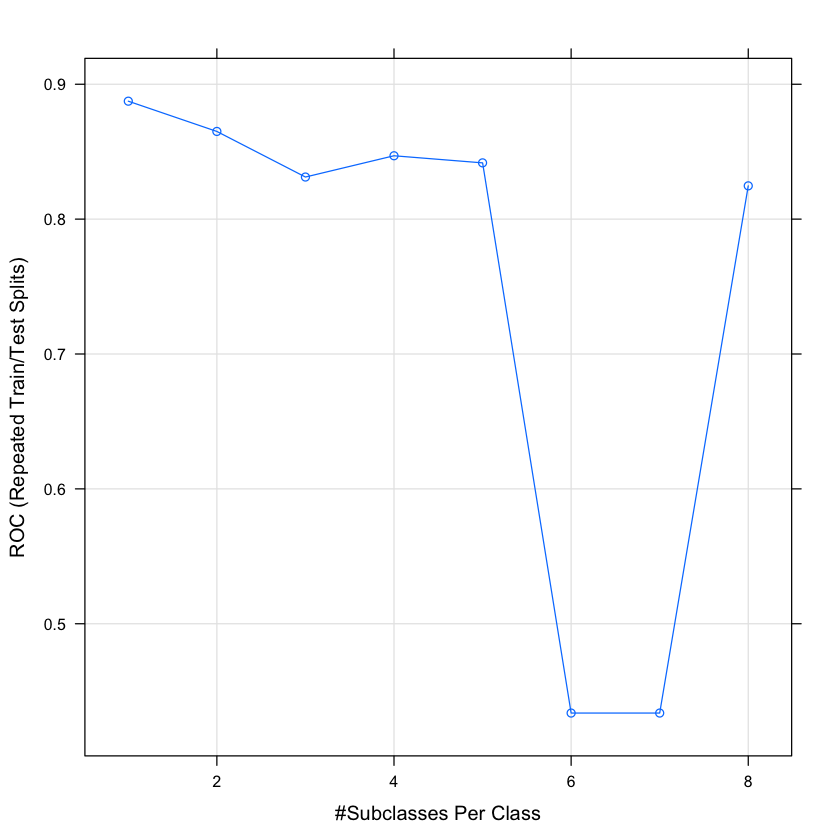

In [12]:
plot(mda_fit)

In [13]:
mda_fit$results <- mda_fit$results[!is.na(mda_fit$results$ROC),]                
mda_fit$pred <- merge(mda_fit$pred,  mda_fit$bestTune)
mdaCM <- confusionMatrix(mda_fit, norm = "none")
mdaCM

Repeated Train/Test Splits Estimated (1 reps, 75%) Confusion Matrix 

(entries are un-normalized aggregated counts)
 
Confusion Matrix and Statistics

              Reference
Prediction     successful unsuccessful
  successful          462          176
  unsuccessful        108          811
                                          
               Accuracy : 0.8176          
                 95% CI : (0.7975, 0.8365)
    No Information Rate : 0.6339          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.6167          
 Mcnemar's Test P-Value : 7.017e-05       
                                          
            Sensitivity : 0.8105          
            Specificity : 0.8217          
         Pos Pred Value : 0.7241          
         Neg Pred Value : 0.8825          
             Prevalence : 0.3661          
         Detection Rate : 0.2967          
   Detection Prevalence : 0.4098          
      Balanced Accur

ERROR: Error in roc(response = mda_fit$pred$obs, predictor = mda_fit$pred$successful, : 没有"roc"这个函数



Call:
roc.default(response = mda_fit$pred$obs, predictor = mda_fit$pred$successful,     levels = rev(levels(mda_fit$pred$obs)))

Data: mda_fit$pred$successful in 987 controls (mda_fit$pred$obs unsuccessful) < 570 cases (mda_fit$pred$obs successful).
Area under the curve: 0.8874

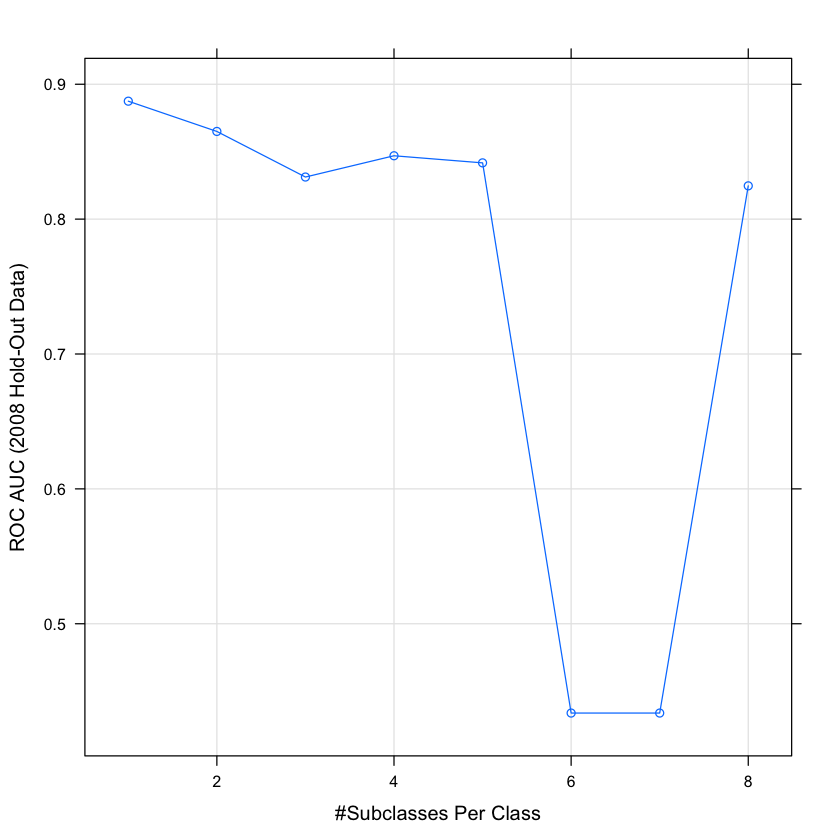

In [17]:
library(pROC)
mdaRoc <- roc(response = mda_fit$pred$obs,
              predictor = mda_fit$pred$successful,
              levels = rev(levels(mda_fit$pred$obs)))
mdaRoc

update(plot(mda_fit,
            ylab = "ROC AUC (2008 Hold-Out Data)"))

`Neural Networks`

In [4]:
library(nnet)
head(class.ind(training$Class))

successful,unsuccessful
1,0
1,0
1,0
1,0
0,1
1,0


In [5]:
set.seed(800)
fit_nnet <- nnet(Class~NumCI+CI.1960,
                data=training[pre2008,],
                size=3,decay=.1)

# weights:  13
initial  value 4802.892391 
iter  10 value 4595.629073
iter  20 value 4584.893054
iter  30 value 4582.614616
iter  40 value 4581.010289
iter  50 value 4580.866146
iter  60 value 4580.781092
iter  70 value 4580.756342
final  value 4580.756133 
converged


In [6]:
fit_nnet

a 2-3-1 network with 13 weights
inputs: NumCI CI.1960 
output(s): Class 
options were - entropy fitting  decay=0.1

In [7]:
predict(fit_nnet,newdata = head(testing),type="class")

[1] "unsuccessful" "unsuccessful" "unsuccessful" "unsuccessful" "successful"  
[6] "unsuccessful"

In [ ]:
nnetGrid <- expand.grid(size = 1:10, decay = c(0, .1, 1, 2))
maxSize <- max(nnetGrid$size)

set.seed(476)
nnetFit <- train(
                x=training[,reducedSet],
                y=training$Class,
                method="nnet",
                metric="ROC",
                preProc=c("center","scale"),
                tuneGrid=nnetGrid,
                trace=F,maxit=2000,
                MaxNWts=1*(maxSize * (length(reducedSet) + 1) + maxSize + 1),
                trControl=ctrl)

In [ ]:
nnetFit

`Using deep.learning from H2o instead`

In [82]:
library(h2o)
h2o.init(port = 54322)


H2O is not running yet, starting it now...

Note:  In case of errors look at the following log files:
    /var/folders/hz/mgxk98c511v7yyg3fczrtyt40000gn/T//RtmpBpLmL3/h2o_randall_started_from_r.out
    /var/folders/hz/mgxk98c511v7yyg3fczrtyt40000gn/T//RtmpBpLmL3/h2o_randall_started_from_r.err


Starting H2O JVM and connecting: . Connection successful!

R is connected to the H2O cluster: 
    H2O cluster uptime:         1 minutes 20 seconds 
    H2O cluster timezone:       Asia/Shanghai 
    H2O data parsing timezone:  UTC 
    H2O cluster version:        3.20.0.2 
    H2O cluster version age:    3 months and 18 days !!! 
    H2O cluster name:           H2O_started_from_R_randall_hjo318 
    H2O cluster total nodes:    1 
    H2O cluster total memory:   1.78 GB 
    H2O cluster total cores:    4 
    H2O cluster allowed cores:  4 
    H2O cluster healthy:        TRUE 
    H2O Connection ip:          localhost 
    H2O Connection port:        54322 
    H2O Connection proxy:       NA 
 

Warning message in h2o.clusterInfo():
“
Your H2O cluster version is too old (3 months and 18 days)!
Please download and install the latest version from http://h2o.ai/download/”

In [11]:
h2o.clusterInfo()

R is connected to the H2O cluster: 
    H2O cluster uptime:         1 minutes 42 seconds 
    H2O cluster timezone:       Asia/Shanghai 
    H2O data parsing timezone:  UTC 
    H2O cluster version:        3.20.0.2 
    H2O cluster version age:    3 months and 18 days !!! 
    H2O cluster name:           H2O_started_from_R_randall_ogj185 
    H2O cluster total nodes:    1 
    H2O cluster total memory:   1.77 GB 
    H2O cluster total cores:    4 
    H2O cluster allowed cores:  4 
    H2O cluster healthy:        TRUE 
    H2O Connection ip:          localhost 
    H2O Connection port:        54322 
    H2O Connection proxy:       NA 
    H2O Internal Security:      FALSE 
    H2O API Extensions:         XGBoost, Algos, AutoML, Core V3, Core V4 
    R Version:                  R version 3.4.3 (2017-11-30) 


Warning message in h2o.clusterInfo():
“
Your H2O cluster version is too old (3 months and 18 days)!
Please download and install the latest version from http://h2o.ai/download/”

In [12]:
str(df)

 chr [1:5] "training" "testing" "pre2008" "fullSet" "reducedSet"


In [ ]:
preProcValues <- preProcess(training, method = c("center", "scale"))

trainTransformed <- predict(preProcValues, training)
testTransformed <- predict(preProcValues, test)

In [16]:
library(caret)
training_cs <- predict(preProcess(training,method=c("center","scale")),training)

In [17]:
training_hex <- as.h2o(training_cs)

  |======================================================================| 100%


In [64]:
grid_nn <- h2o.grid("deeplearning",x=reducedSet,y="Class",stopping_metric = "AUC",nfolds=10,
                    training_frame = training_hex[pre2008,],validation_frame=training_hex[-pre2008,],
                   hyper_params =list(hidden=c(1:10),l1=c(0, .1, 1, 2),l2=c(0, .1, 1, 2)))

  |======================================================================| 100%


In [65]:
h2o.getGrid(grid_nn@grid_id,sort_by = "auc",decreasing = T)

H2O Grid Details

Grid ID: Grid_DeepLearning_RTMP_sid_a310_12_model_R_1538622372200_3084 
Used hyper parameters: 
  -  hidden 
  -  l1 
  -  l2 
Number of models: 160 
Number of failed models: 0 

Hyper-Parameter Search Summary: ordered by decreasing auc
  hidden  l1  l2
1    [9] 0.0 0.1
2    [4] 0.0 0.1
3    [3] 0.0 0.1
4    [5] 0.0 0.1
5    [8] 0.0 0.1
                                                               model_ids
1 Grid_DeepLearning_RTMP_sid_a310_12_model_R_1538622372200_3084_model_48
2 Grid_DeepLearning_RTMP_sid_a310_12_model_R_1538622372200_3084_model_43
3 Grid_DeepLearning_RTMP_sid_a310_12_model_R_1538622372200_3084_model_42
4 Grid_DeepLearning_RTMP_sid_a310_12_model_R_1538622372200_3084_model_44
5 Grid_DeepLearning_RTMP_sid_a310_12_model_R_1538622372200_3084_model_47
                 auc
1 0.8930366696884054
2 0.8923194511100446
3 0.8872687036740788
4 0.8866839083524414
5 0.8835919586199541

---
    hidden  l1  l2
155    [5] 2.0 0.0
156    [9] 1.0 2.0
157    [3] 1.0 0.

In [44]:
training_ss <- predict(preProcess(training,method=c("center","scale","spatialSign")),training)
training_trans_hex <- as.h2o(training_ss)

  |======================================================================| 100%


In [66]:
grid_nn2 <- h2o.grid("deeplearning",x=reducedSet,y="Class",stopping_metric = "AUC",
                    training_frame = training_trans_hex[pre2008,],validation_frame=training_trans_hex[-pre2008,],
                   hyper_params =list(hidden=c(1:10),l1=c(0, .1, 1, 2),l2=c(0, .1, 1, 2)))

  |======================================================================| 100%


In [67]:
h2o.getGrid(grid_nn2@grid_id,sort_by = "auc",decreasing = T)

H2O Grid Details

Grid ID: Grid_DeepLearning_RTMP_sid_a310_14_model_R_1538622372200_3933 
Used hyper parameters: 
  -  hidden 
  -  l1 
  -  l2 
Number of models: 160 
Number of failed models: 0 

Hyper-Parameter Search Summary: ordered by decreasing auc
  hidden  l1  l2
1    [4] 0.0 0.0
2    [3] 0.0 0.0
3    [9] 0.0 0.0
4    [7] 0.0 0.0
5    [3] 0.0 0.1
                                                               model_ids
1  Grid_DeepLearning_RTMP_sid_a310_14_model_R_1538622372200_3933_model_3
2  Grid_DeepLearning_RTMP_sid_a310_14_model_R_1538622372200_3933_model_2
3  Grid_DeepLearning_RTMP_sid_a310_14_model_R_1538622372200_3933_model_8
4  Grid_DeepLearning_RTMP_sid_a310_14_model_R_1538622372200_3933_model_6
5 Grid_DeepLearning_RTMP_sid_a310_14_model_R_1538622372200_3933_model_42
                 auc
1 0.8744494214259052
2 0.8729047796796956
3   0.87285234362502
4 0.8678575872304876
5 0.8672630156952665

---
    hidden  l1  l2
155    [6] 2.0 0.0
156    [3] 2.0 2.0
157    [1] 0.1 0.

In [68]:
fit_nnet1 <- h2o.deeplearning(x=reducedSet,y="Class",stopping_metric = "AUC",
                    training_frame = training_hex[pre2008,],validation_frame=training_hex[-pre2008,])

  |======================================================================| 100%


In [69]:
fit_nnet2 <- h2o.deeplearning(x=reducedSet,y="Class",stopping_metric = "AUC",
                    training_frame = training_trans_hex[pre2008,],validation_frame=training_trans_hex[-pre2008,])

  |======================================================================| 100%


In [73]:
fit_nnet1

Model Details:

H2OBinomialModel: deeplearning
Model ID:  DeepLearning_model_R_1538622372200_4778 
Status of Neuron Layers: predicting Class, 2-class classification, bernoulli distribution, CrossEntropy loss, 91,202 weights/biases, 1.1 MB, 66,330 training samples, mini-batch size 1
  layer units      type dropout       l1       l2 mean_rate rate_rms momentum
1     1   252     Input  0.00 %                                              
2     2   200 Rectifier  0.00 % 0.000000 0.000000  0.017149 0.016647 0.000000
3     3   200 Rectifier  0.00 % 0.000000 0.000000  0.020210 0.059466 0.000000
4     4     2   Softmax         0.000000 0.000000  0.002478 0.001322 0.000000
  mean_weight weight_rms mean_bias bias_rms
1                                          
2    0.015608   0.071221  0.414500 0.035228
3   -0.010722   0.075059  0.972911 0.016843
4    0.009054   0.395867  0.000180 0.012448


H2OBinomialMetrics: deeplearning
** Reported on training data. **
** Metrics reported on full training fr

In [74]:
fit_nnet2

Model Details:

H2OBinomialModel: deeplearning
Model ID:  DeepLearning_model_R_1538622372200_4787 
Status of Neuron Layers: predicting Class, 2-class classification, bernoulli distribution, CrossEntropy loss, 91,202 weights/biases, 1.1 MB, 66,330 training samples, mini-batch size 1
  layer units      type dropout       l1       l2 mean_rate rate_rms momentum
1     1   252     Input  0.00 %                                              
2     2   200 Rectifier  0.00 % 0.000000 0.000000  0.022898 0.024137 0.000000
3     3   200 Rectifier  0.00 % 0.000000 0.000000  0.020367 0.060636 0.000000
4     4     2   Softmax         0.000000 0.000000  0.003047 0.001567 0.000000
  mean_weight weight_rms mean_bias bias_rms
1                                          
2    0.009708   0.075077  0.401896 0.048708
3   -0.012021   0.075794  0.972494 0.016928
4   -0.042697   0.388592 -0.000013 0.022723


H2OBinomialMetrics: deeplearning
** Reported on training data. **
** Metrics reported on full training fr

In [85]:
# trn <- as.h2o(training)
h2o.deeplearning(x=reducedSet,y="Class",stopping_metric = "AUC",nfolds=10,
                    training_frame = trn[pre2008,],validation_frame=trn[-pre2008,])

  |======================================================================| 100%


Model Details:

H2OBinomialModel: deeplearning
Model ID:  DeepLearning_model_R_1538630624348_12 
Status of Neuron Layers: predicting Class, 2-class classification, bernoulli distribution, CrossEntropy loss, 91,202 weights/biases, 1.1 MB, 78,605 training samples, mini-batch size 1
  layer units      type dropout       l1       l2 mean_rate rate_rms momentum
1     1   252     Input  0.00 %                                              
2     2   200 Rectifier  0.00 % 0.000000 0.000000  0.028576 0.024657 0.000000
3     3   200 Rectifier  0.00 % 0.000000 0.000000  0.017348 0.067143 0.000000
4     4     2   Softmax         0.000000 0.000000  0.003494 0.001955 0.000000
  mean_weight weight_rms mean_bias bias_rms
1                                          
2    0.005579   0.076519  0.434397 0.036456
3   -0.012300   0.075347  0.971531 0.017084
4    0.043175   0.395603  0.001009 0.038492


H2OBinomialMetrics: deeplearning
** Reported on training data. **
** Metrics reported on full training fram

In [86]:
h2o.shutdown()

Are you sure you want to shutdown the H2O instance running at http://localhost:54322/ (Y/N)? Y


[1] TRUE

`Flexible Discriminant Analysis`

In [ ]:
# set.seed(476)
# fdaFit <- train(x = training[,reducedSet], 
#                 y = training$Class,
#                 method = "fda",
#                 metric = "ROC",
#                 tuneGrid = expand.grid(degree = 1, nprune = 2:25),
#                 trControl = ctrl)
# fdaFit

# fdaFit$pred <- merge(fdaFit$pred,  fdaFit$bestTune)
# fdaCM <- confusionMatrix(fdaFit, norm = "none")
# fdaCM

# fdaRoc <- roc(response = fdaFit$pred$obs,
#               predictor = fdaFit$pred$successful,
#               levels = rev(levels(fdaFit$pred$obs)))

# update(plot(fdaFit), ylab = "ROC AUC (2008 Hold-Out Data)")

# plot(nnetRoc, type = "s", col = rgb(.2, .2, .2, .2), legacy.axes = TRUE)
# plot(fdaRoc, type = "s", add = TRUE, legacy.axes = TRUE)

`Support Vector Machines`

In [ ]:
# library(kernlab)

# set.seed(201)
# sigmaRangeFull <- sigest(as.matrix(training[,fullSet]))
# svmRGridFull <- expand.grid(sigma =  as.vector(sigmaRangeFull)[1],
#                             C = 2^(-3:4))
# set.seed(476)
# svmRFitFull <- train(x = training[,fullSet], 
#                      y = training$Class,
#                      method = "svmRadial",
#                      metric = "ROC",
#                      preProc = c("center", "scale"),
#                      tuneGrid = svmRGridFull,
#                      trControl = ctrl)
# svmRFitFull

# set.seed(202)
# sigmaRangeReduced <- sigest(as.matrix(training[,reducedSet]))
# svmRGridReduced <- expand.grid(sigma = sigmaRangeReduced[1],
#                                C = 2^(seq(-4, 4)))
# set.seed(476)
# svmRFitReduced <- train(x = training[,reducedSet], 
#                         y = training$Class,
#                         method = "svmRadial",
#                         metric = "ROC",
#                         preProc = c("center", "scale"),
#                         tuneGrid = svmRGridReduced,
#                         trControl = ctrl)
# svmRFitReduced

# svmPGrid <-  expand.grid(degree = 1:2,
#                          scale = c(0.01, .005),
#                          C = 2^(seq(-6, -2, length = 10)))

# set.seed(476)
# svmPFitFull <- train(x = training[,fullSet], 
#                      y = training$Class,
#                      method = "svmPoly",
#                      metric = "ROC",
#                      preProc = c("center", "scale"),
#                      tuneGrid = svmPGrid,
#                      trControl = ctrl)
# svmPFitFull

# svmPGrid2 <-  expand.grid(degree = 1:2,
#                           scale = c(0.01, .005),
#                           C = 2^(seq(-6, -2, length = 10)))
# set.seed(476)
# svmPFitReduced <- train(x = training[,reducedSet], 
#                         y = training$Class,
#                         method = "svmPoly",
#                         metric = "ROC",
#                         preProc = c("center", "scale"),
#                         tuneGrid = svmPGrid2,
#                         fit = FALSE,
#                         trControl = ctrl)
# svmPFitReduced

# svmPFitReduced$pred <- merge(svmPFitReduced$pred,  svmPFitReduced$bestTune)
# svmPCM <- confusionMatrix(svmPFitReduced, norm = "none")
# svmPRoc <- roc(response = svmPFitReduced$pred$obs,
#                predictor = svmPFitReduced$pred$successful,
#                levels = rev(levels(svmPFitReduced$pred$obs)))


# svmRadialResults <- rbind(svmRFitReduced$results,
#                           svmRFitFull$results)
# svmRadialResults$Set <- c(rep("Reduced Set", nrow(svmRFitReduced$result)),
#                           rep("Full Set", nrow(svmRFitFull$result)))
# svmRadialResults$Sigma <- paste("sigma = ", 
#                                 format(svmRadialResults$sigma, 
#                                        scientific = FALSE, digits= 5))
# svmRadialResults <- svmRadialResults[!is.na(svmRadialResults$ROC),]
# xyplot(ROC ~ C|Set, data = svmRadialResults,
#        groups = Sigma, type = c("g", "o"),
#        xlab = "Cost",
#        ylab = "ROC (2008 Hold-Out Data)",
#        auto.key = list(columns = 2),
#        scales = list(x = list(log = 2)))

# svmPolyResults <- rbind(svmPFitReduced$results,
#                         svmPFitFull$results)
# svmPolyResults$Set <- c(rep("Reduced Set", nrow(svmPFitReduced$result)),
#                         rep("Full Set", nrow(svmPFitFull$result)))
# svmPolyResults <- svmPolyResults[!is.na(svmPolyResults$ROC),]
# svmPolyResults$scale <- paste("scale = ", 
#                               format(svmPolyResults$scale, 
#                                      scientific = FALSE))
# svmPolyResults$Degree <- "Linear"
# svmPolyResults$Degree[svmPolyResults$degree == 2] <- "Quadratic"
# useOuterStrips(xyplot(ROC ~ C|Degree*Set, data = svmPolyResults,
#                       groups = scale, type = c("g", "o"),
#                       xlab = "Cost",
#                       ylab = "ROC (2008 Hold-Out Data)",
#                       auto.key = list(columns = 2),
#                       scales = list(x = list(log = 2))))

# plot(nnetRoc, type = "s", col = rgb(.2, .2, .2, .2), legacy.axes = TRUE)
# plot(fdaRoc, type = "s", add = TRUE, col = rgb(.2, .2, .2, .2), legacy.axes = TRUE)
# plot(svmPRoc, type = "s", add = TRUE, legacy.axes = TRUE)